<a href="https://colab.research.google.com/github/colettebas/Interpreting-CnC-in-NLP-Domains/blob/main/Demo_Loading_CnC_Model_and_Using_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running this notebook, you must add the models and data to your drive.

Access the CS690F_CnC_Project using [this link](https://drive.google.com/drive/folders/1rcbefukUa0dd3XJNtf_73dTV0uUR_cdv?usp=sharing).

Click on the arrow next to CS690F_CnC_Project and from the drop down select "Add shortcut to Drive"

In the pop-up, ensure that My Drive is highlighted in blue then click "Add Shortcut"

In [1]:
!pip install pandas
!pip install shap
!pip install torch
!pip install transformers

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 63.4 MB/s 
     |████████████████████████████████| 7.6 MB 51.6 MB/s 
Mounted at /content/drive


We will be using pretrained models that are provided by the authors of Correct-N-Contrast. These models are based on the BERT models from the transformers library. We must load the base model from the transformers class which will then be used to load the pretrained models. 



In [2]:
from transformers import BertForSequenceClassification, BertConfig


config_class = BertConfig
model_class = BertForSequenceClassification


model_name = 'bert-base-uncased'
num_classes = 2
task = 'civilcomments'

config = config_class.from_pretrained(model_name,num_labels=num_classes,finetuning_task=task)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
net = model_class.from_pretrained(model_name, from_tf=False, config=config)

net.activation_layer = 'bert.pooler.activation'

base_model = net

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The following method comes from the source code for Correct-N-Contrast.  The authors checkpoint models and then use the following method to load the checkpoints.  We will be doing the same using the final ERM model and Correct-N-Contrast Models as our checkpoints. 

In [4]:
def load_encoder_state_dict(model, state_dict, contrastive_train=False):
    # Remove 'backbone' prefix for loading into model
    if contrastive_train:
        log = model.load_state_dict(state_dict, strict=False)
        for k in list(state_dict.keys()):
            print(k)
    else:
        for k in list(state_dict.keys()):
            if k.startswith('backbone.'):  
                # Corrected for CNN
                if k.startswith('backbone.fc1') or k.startswith('backbone.fc2'):
                    state_dict[k[len("backbone."):]] = state_dict[k]
                # Should also be corrected for BERT models
                elif (k.startswith('backbone.fc') or
                      k.startswith('backbone.classifier')):
                    pass
                else:
                    state_dict[k[len("backbone."):]] = state_dict[k]
                del state_dict[k]
        log = model.load_state_dict(state_dict, strict=False)
    print(f'log.missing_keys: {log.missing_keys}')
    return model

In [15]:
import torch

cnc_checkpoint_name = '/content/drive/MyDrive/CS690F_CnC_Project/civilcomments_cnc_pretrained.pth.tar'
cnc_model_state_dict = torch.load(cnc_checkpoint_name, map_location=torch.device('cpu'))
cnc_model_state_dict = cnc_model_state_dict['model_state_dict']
cnc_model = load_encoder_state_dict(base_model, cnc_model_state_dict, contrastive_train=False)

log.missing_keys: []


In [6]:
erm_checkpoint_name = '/content/drive/MyDrive/CS690F_CnC_Project/civilcomments_erm_early.pth.tar'
erm_model_state_dict = torch.load(erm_checkpoint_name, map_location=torch.device('cpu'))
erm_model_state_dict = erm_model_state_dict['model_state_dict']
erm_model = load_encoder_state_dict(base_model, erm_model_state_dict, contrastive_train=False)

log.missing_keys: []


In [16]:
print(type(erm_model))
print(type(cnc_model))

<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


Now that the models are loaded, we can create an explainer using the SHAP library.  This explainer takes in a transformers pipeline as an argument. To create this pipeline, we pass in the loaded models and BERT tokenizer from the transformers library. 

In [17]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [9]:
import transformers
# build a pipeline object to do predictions
erm_pred = transformers.pipeline("text-classification", model=erm_model, tokenizer=tokenizer, device=-1, return_all_scores=True)
cnc_pred = transformers.pipeline("text-classification", model=cnc_model, tokenizer=tokenizer, device=-1, return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:92: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


In [18]:
import shap

erm_explainer = shap.Explainer(erm_pred)
cnc_explainer = shap.Explainer(cnc_pred)

We now need to load a dataset for the explainer to use find the SHAP values for various samples.  We use the same Civil Comments-WILDS dataset that the authors of Correct-N-Contrast use.  A link to this dataset can be found in the README for Correct-N-Contrast.  The toxicity scores are values between 0 and 1.  We follow the authors of Correct-N-Contrast and classify any value greater than or equal to 0.5 as toxic and any value less than 0.5 as not toxic.

In [11]:
#import datasets
import pandas as pd

# load the civil comments dataset
#dataset  = datasets.load_dataset("civil_comments", split = "train")
dataset = pd.read_csv('/content/drive/MyDrive/CS690F_CnC_Project/all_data_with_identities.csv')

#translate toxicity values to labels
dataset.loc[dataset["toxicity"] >= 0.5, "toxicity"] = 1
dataset.loc[dataset["toxicity"] < 0.5, "toxicity"] = 0

data = pd.DataFrame({'text':dataset['comment_text'],'toxic':dataset['toxicity']})


We now feed the first three samples to the explainers and visualize the influence of each word on the predicition of toxic or not toxic.

In [12]:
erm_shap_values = erm_explainer(data['text'][:3])
shap.plots.text(erm_shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [08:47<00:00, 184.75s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer: 4it [09:06, 182.22s/it]


In [19]:
cnc_shap_values = cnc_explainer(data['text'][:3])
shap.plots.text(cnc_shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [08:38<00:00, 181.42s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer: 4it [08:57, 179.01s/it]


We can also visualize the words which had the greatest overall influence on the predictions for all three samples. 

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


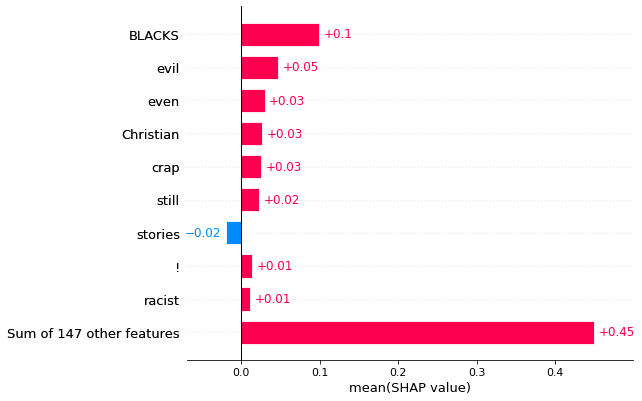

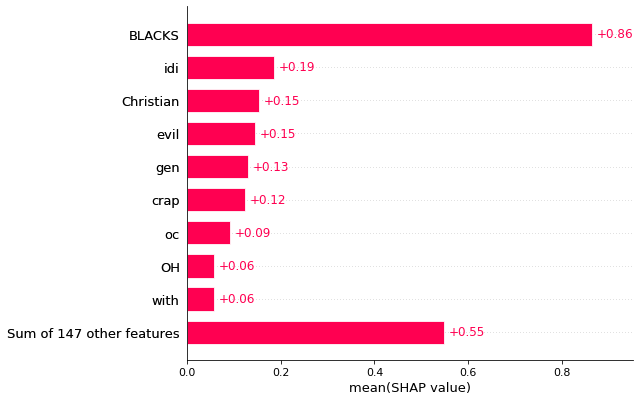

In [20]:
# Here we find the mean of the features that contribute to classifying a comment as
# toxic which is class label 1.
shap.plots.bar(erm_shap_values[:,:,1].mean(0))
shap.plots.bar(cnc_shap_values[:,:,1].mean(0))
